In [121]:
import numpy as np 
from numpy import random
import pandas as pd 
from collections import deque
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pygame 
import time 
import os
import pickle


In [122]:
class Maze:
    def __init__(self,grid):
        self.grid=grid
        self.n_actions=4
        self.actions=[0,1,2,3]
        self.cell_size = 40  
        self.width = len(grid[0])
        self.height = len(grid)
        self.screen = None
    def initialize_display(self):
        pygame.init()
        self.screen = pygame.display.set_mode((self.width * self.cell_size, self.height * self.cell_size))
        pygame.display.set_caption("Trained DQN Maze")
        self.clock = pygame.time.Clock()
    def render(self):
        if self.screen is None:
            self.initialize_display()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()

        colors = {
            0: (255, 255, 255),  
            1: (0, 0, 0),        
        }
        agent_color = (0, 255, 0)
        death_eater_color = (255, 0, 0)
        goal_color = (0, 0, 255)

      
        for x in range(self.height):
            for y in range(self.width):
                color = colors[self.grid[x][y]]
                pygame.draw.rect(
                    self.screen,
                    color,
                    pygame.Rect(y * self.cell_size, x * self.cell_size, self.cell_size, self.cell_size)
                )

       
        ax, ay = self.state[0], self.state[1]
        pygame.draw.rect(self.screen, agent_color,
                        pygame.Rect(ay * self.cell_size, ax * self.cell_size, self.cell_size, self.cell_size))

        
        dx, dy = self.state[2], self.state[3]
        pygame.draw.rect(self.screen, death_eater_color,
                        pygame.Rect(dy * self.cell_size, dx * self.cell_size, self.cell_size, self.cell_size))

     
        gx, gy = self.state[4], self.state[5]
        pygame.draw.rect(self.screen, goal_color,
                        pygame.Rect(gy * self.cell_size, gx * self.cell_size, self.cell_size, self.cell_size))

        pygame.display.flip()
        
    def initial_state(self):
        while 1 :
            x1=random.randint(0,9)
            y1=random.randint(0,14)
            if(self.grid[x1][y1]!=1):
                break
        while 1 :
            x2=random.randint(0,9)
            y2=random.randint(0,14)
            if(self.grid[x2][y2]!=1):
                break
        while 1 :
            x=random.randint(0,9)
            y=random.randint(0,14)
            if(self.grid[x][y]!=1):
                break
        self.state=[x1,y1,x2,y2,x,y]
        return self.state
    def death_eater(self):
        visited=set()
        start = (self.state[2], self.state[3])  
        goal = (self.state[0], self.state[1])  
        queue = deque()
        parent = {}
        queue.append(start)
        visited.add(start)
        
        while queue:
            curr = queue.popleft()
            if curr == goal:
                break
            for dx, dy, a in [(-1, 0, 0), (1, 0, 1), (0, -1, 2), (0, 1, 3)]:
                nx, ny = curr[0] + dx, curr[1] + dy
                if 0 <= nx < 10 and 0 <= ny < 15 and self.grid[nx][ny] != 1 and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    parent[(nx, ny)] = (curr, a)
                    queue.append((nx, ny))
        
        if goal not in parent:
            return -1  

      
        node = goal
        while parent[node][0] != start:
            node = parent[node][0]
        return parent[node][1] 

    def death_eater_action(self):
        action=self.death_eater()
        if action==-1:
            return False,self.state[2],self.state[3]
        done=False
        x,y=self.state[2],self.state[3]
        next_state_x=x
        next_state_y=y
        if action==0 and x!=0 and self.grid[x-1][y]!=1:
            if(x-1==self.state[0] and y==self.state[1]):
                done=True
            next_state_x=x-1
            next_state_y=y
        elif action==1 and x!=9 and self.grid[x+1][y]!=1:
            if(x+1==self.state[0] and y==self.state[1]):
                done=True
            next_state_x=x+1
            next_state_y=y
        elif action==2 and y!=0 and self.grid[x][y-1]!=1:
            if(x==self.state[0] and y-1==self.state[1]):
                done=True
            next_state_x=x
            next_state_y=y-1
        elif action==3 and y!=14 and self.grid[x][y+1]!=1:
            if(x==self.state[0] and y+1==self.state[1]):
                done=True
            next_state_x=x
            next_state_y=y+1
        self.state[2]=next_state_x
        self.state[3]=next_state_y
        return done,next_state_x,next_state_y
    def action_(self,action):
        reward=0
        done=False
        x,y=self.state[0],self.state[1]
        next_state_x=x
        next_state_y=y
        if action==0 and x!=0 and self.grid[x-1][y]!=1:
            if(x-1==self.state[4] and y==self.state[5]):
                reward=100
                done=True
            else:
                reward=0
            next_state_x=x-1
            next_state_y=y
        elif action==1 and x!=9 and self.grid[x+1][y]!=1:
            if(x+1==self.state[4] and y==self.state[5]):
                reward=100
                done=True
            else:
                reward=0
            next_state_x=x+1
            next_state_y=y
        elif action==2 and y!=0 and self.grid[x][y-1]!=1:
            if(x==self.state[4] and y-1==self.state[5]):
                reward=100
                done=True
            else:
                reward=0
            next_state_x=x
            next_state_y=y-1
        elif action==3 and y!=14 and self.grid[x][y+1]!=1:
            if(x==self.state[4] and y+1==self.state[5]):
                reward=100
                done=True
            else:
                reward=0
            next_state_x=x
            next_state_y=y+1
        else:
            reward=0
        self.state[0]=next_state_x
        self.state[1]=next_state_y
        if(next_state_x==self.state[2] and next_state_y==self.state[3]):
            done=True
            reward=-10
        
        return reward,done,next_state_x,next_state_y


        

In [123]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((list(state), action, reward, list(next_state), done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states_array = np.array(states)              
        actions_array = np.array(actions)            
        rewards_array = np.array(rewards)          
        next_states_array = np.array(next_states)    
        dones_array = np.array(dones)                
        return (states_array, actions_array, rewards_array, next_states_array, dones_array)


In [124]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())



In [ ]:
grid = [
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [1,0,1,1,0,1,0,1,0,1,1,0,0,0,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [1,0,1,0,0,1,1,0,1,1,0,0,1,0,1],
    [1,0,0,0,1,0,0,1,0,1,0,1,0,1,1],
    [1,0,0,0,1,0,0,0,0,0,0,0,1,0,1],
    [1,0,1,0,0,1,1,0,1,0,0,0,0,0,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
]

env=Maze(grid)
policy=DQN(6,4)
def clamp(val, min_val, max_val):
    return max(min_val, min(val, max_val - 1))
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
if os.path.exists("training_state.pkl"):
    with open("training_state.pkl", "rb") as f:
        saved_data = pickle.load(f)
        optimizer.load_state_dict(saved_data["optimizer_state"])
        buffer = saved_data["buffer"]
else:
    buffer = ReplayBuffer(10000)
target=DQN(6,4)
update_target(policy,target)
BATCH_SIZE=32
GAMMA=0.9
loss_fn = nn.MSELoss()

episode_rewards=[]
epsilon=1
success=[]
episodes=1000
for episode in range(episodes):
    state=env.initial_state()
    reward_ep=0
    done=False
    ep_success=0
    max_steps=300
    steps=0
    while not done and steps<=max_steps :
        env.render()
        time.sleep(0.2)
        steps+=1 
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        if random.random()<epsilon :
            action=random.randint(0,3)
        else :
            with torch.no_grad():
                q_values = policy(state_tensor)
                action = q_values.argmax().item()
        reward,done1,x1,y1=env.action_(action)
        if(x1==state[4] and y1==state[5]):
            ep_success=1
        done2,x2,y2=env.death_eater_action()
        x1 = clamp(x1, 0, len(grid))
        y1 = clamp(y1, 0, len(grid[0]))
        x2 = clamp(x2, 0, len(grid))
        y2 = clamp(y2, 0, len(grid[0]))
        if done2==True and ep_success !=1:
            reward=-10
        reward_ep+=reward
        x1 = clamp(x1, 0, len(grid))
        y1 = clamp(y1, 0, len(grid[0]))
        x2 = clamp(x2, 0, len(grid))
        y2 = clamp(y2, 0, len(grid[0]))
        next_state=[x1,y1,x2,y2,state[4],state[5]]
        buffer.push(state,action,reward,next_state,done1 or done2)
        done=done1 or done2
        state=next_state
        if len(buffer.buffer) >= BATCH_SIZE:
            states_b, actions_b, rewards_b, next_states_b, dones_b = buffer.sample(BATCH_SIZE)

            states_tensor = torch.FloatTensor(states_b)
            actions_tensor = torch.LongTensor(actions_b).unsqueeze(1)
            rewards_tensor = torch.FloatTensor(rewards_b).unsqueeze(1)
            next_states_tensor = torch.FloatTensor(next_states_b)
            dones_tensor = torch.BoolTensor(dones_b).unsqueeze(1)
            q_values = policy(states_tensor).gather(1, actions_tensor)
            with torch.no_grad():
                max_next_q_values = target(next_states_tensor).max(1)[0].unsqueeze(1)
                target_q_values = rewards_tensor +  GAMMA * max_next_q_values
            loss = loss_fn(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    episode_rewards.append(reward_ep)
    if episode % 5 == 0:
        update_target(policy, target)
    epsilon = max(0.01, epsilon * 0.99)
    success.append(ep_success)
with open("training_state.pkl", "wb") as f:
    pickle.dump({
        "buffer": buffer,
        "epsilon": epsilon,
        "episode_rewards": episode_rewards,
        "success": success,
        "optimizer_state": optimizer.state_dict()
    }, f)
c=0
for i in range(episodes):
    if(success[i]==1):
        c+=1
print(f'Success Rate = {c*100/episodes}%')



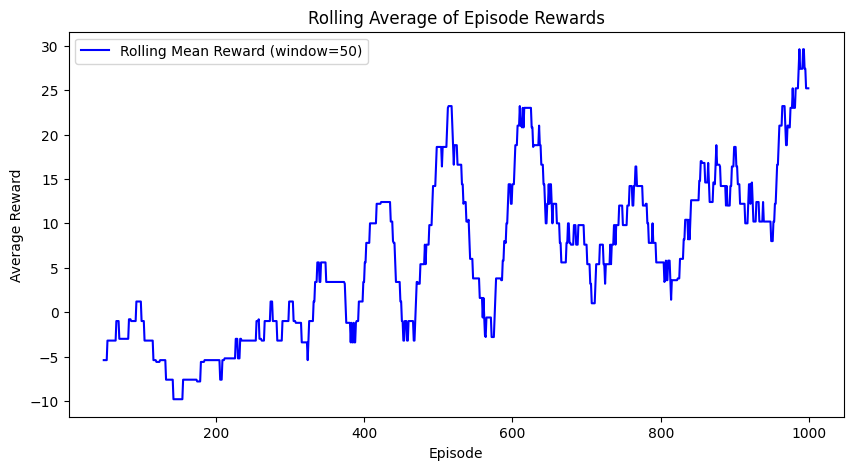

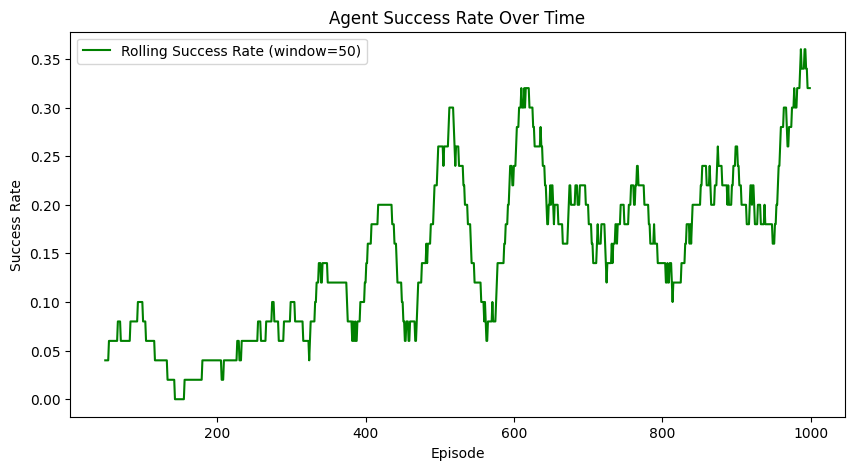

In [ ]:
rewards_series = pd.Series(episode_rewards)


rolling_mean = rewards_series.rolling(window=50).mean()


plt.figure(figsize=(10, 5))
plt.plot(rolling_mean, label="Rolling Mean Reward (window=50)", color='blue')
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Rolling Average of Episode Rewards")
plt.legend()
plt.show()

window_size = 50  
rolling_success = pd.Series(success).rolling(window=window_size).mean()

plt.figure(figsize=(10, 5))
plt.plot(rolling_success, label=f"Rolling Success Rate (window={window_size})", color="green")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Agent Success Rate Over Time")
plt.legend()
plt.show()